# 🔵 **Dependencies**




In [ ]:
!pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 840.4/840.4 kB 5.5 MB/s eta 0:00:00


In [ ]:
#for windows
!pip install -q soundfile
#for linux
!pip install -q sox

In [ ]:
!pip install -q librosa

In [ ]:
!pip install -q einops

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 974.5 kB/s eta 0:00:00


# 🔵 **Imports**

In [ ]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, random_split, Dataset
import torch.nn.functional as F

import torchaudio
from torchaudio import datasets
from torchaudio import transforms as T
from torchaudio import models
from torchaudio import pipelines

from torch.nn.utils.rnn import pad_sequence

import torchtext
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

from torchvision import models as extractor


import numpy  as np
import pandas as pd
from scipy.io import loadmat
import matplotlib.pyplot as plt
import torchmetrics as tm
import tqdm
import librosa
from collections import Counter
import math
import gc

from IPython.display import Audio

In [ ]:
!python --version

Python 3.10.12


In [ ]:
for lib in [np, torch, torchaudio, torchtext, pd, tm, librosa]:
  print(lib.__name__, '-->', lib.__version__)

numpy --> 1.25.2
torch --> 2.1.0+cu121
torchaudio --> 2.1.0+cu121
torchtext --> 0.16.0+cpu
pandas --> 1.5.3
torchmetrics --> 1.3.1
librosa --> 0.10.1


# 🔵 **Utils**

In [ ]:
device = 'cuda' if torch.cuda.is_available else 'cpu'
device

'cuda'

In [ ]:
def to_sentence(preds, inputs):
  sentences_preds = []
  for pred in preds:
    indexes = pred.argmax(dim = -1).tolist()
    sentence = [ch_vocab.get_itos()[index] for index in indexes]
    sentence = ''.join(sentence).replace('<sos>', '')
    sentence = sentence.replace('<eos>', '')
    sentence = sentence.replace('<pad>', '')
    sentences_preds.append(''.join(sentence))

  sentences_inputs = []
  for input in inputs:
    indexes = input.tolist()
    sentence = [ch_vocab.get_itos()[index] for index in indexes]
    sentence = ''.join(sentence).replace('<sos>', '')
    sentence = sentence.replace('<eos>', '')
    sentence = sentence.replace('<pad>', '')
    sentences_inputs.append(sentence)

  return sentences_preds, sentences_inputs

In [ ]:
import torch
from torch import nn
import torch.nn.functional as F
from einops import rearrange


class CTCLoss(nn.Module):
    """Convenient wrapper for CTCLoss that handles log_softmax and taking input/target lengths."""

    def __init__(self, blank: int = 0) -> None:
        """Init method.

        Args:
            blank (int, optional): Blank token. Defaults to 0.
        """
        super().__init__()
        self.blank = blank

    def forward(self, preds: torch.Tensor, targets: torch.Tensor) -> torch.Tensor:
        """Forward method.

        Args:
            preds (torch.Tensor): Model predictions. Tensor of shape (batch, sequence_length, num_classes), or (N, T, C).
            targets (torch.Tensor): Target tensor of shape (batch, max_seq_length). max_seq_length may vary
                per batch.

        Returns:
            torch.Tensor: Loss scalar.
        """
        preds = preds.log_softmax(-1)
        batch, seq_len, classes = preds.shape
        preds = rearrange(preds, "n t c -> t n c") # since ctc_loss needs (T, N, C) inputs
        # equiv. to preds = preds.permute(1, 0, 2), if you don't use einops

        pred_lengths = torch.full(size=(batch,), fill_value=seq_len, dtype=torch.long)
        target_lengths = torch.count_nonzero(targets, axis=1)

        return F.ctc_loss(preds, targets, pred_lengths, pred_lengths, blank=self.blank, zero_infinity=True)

In [ ]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [ ]:
def num_trainable_params(model):
  nums = sum(p.numel() for p in model.parameters() if p.requires_grad)/1e6
  return nums

In [ ]:
def set_seed(seed):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)

In [ ]:
def print_stats(waveform, sample_rate = None, src = None):
  if src:
    print("_" * 10)
    print("Source:", src)
    print("_" * 10)

  if sample_rate:
    print("Sample Rate: ", sample_rate)

  print('Shape: ', tuple(waveform.shape))
  print('DType: ', waveform.dtype)
  print(f" - Max:   {waveform.max().item():6.3f}")
  print(f" - Min:   {waveform.min().item():6.3f}")
  print(f" - Mean:   {waveform.mean().item():6.3f}")
  print(f" - Std Dev:   {waveform.std().item():6.3f}")
  print()
  print(waveform)
  print()

In [ ]:
def plot_waveform(waveform, sample_rate, title = 'Waveform', xlim = None, ylim = None):
  waveform = waveform.numpy()

  num_channels, num_frames = waveform.shape
  time_axis = torch.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(num_channels, 1)
  if num_channels == 1:
    axes = [axes]
  for c in range(num_channels):
    axes[c].plot(time_axis, waveform[c], linewidth = 1)
    axes[c].grid(True)
    if num_channels > 1:
      axes[c].set_ylabel(f'Channels {c + 1}')
    if xlim:
      axes[c].set_xlim(xlim)
    if ylim:
      axes[c].set_ylim(ylim)

    figure.suptitle(title)
    plt.show(block = False)

In [ ]:
def plot_spectrogram(specgram, title = None, ylabel = 'freq_bin'):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(T.AmplitudeToDB()(specgram), origin = 'lower')
  fig.colorbar(im, ax = axs)
  plt.show(block = False)

# 🔵 **Dataset**

## 🟢 **LoadDataset**

In [ ]:
dataset = datasets.LJSPEECH('/content/', 'https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2', download = True)

100%|██████████| 2.56G/2.56G [00:56<00:00, 48.5MB/s]


In [ ]:
len(dataset)

13100

In [ ]:
import csv
with open('/content/LJSpeech-1.1/metadata.csv', "r", newline="") as metadata:
        flist = csv.reader(metadata, delimiter="|", quoting=csv.QUOTE_NONE)
        file = list(flist)

In [ ]:
file[945]

['LJ004-0076',
 '"Disease, cold, famine, nakedness, and contagious and polluted air are not lawful punishments in the hands of the civil magistrates;',
 '"Disease, cold, famine, nakedness, and contagious and polluted air are not lawful punishments in the hands of the civil magistrates;']

In [ ]:
csv_dataset = []
for sent in file:
  csv_dataset.append([sent[0], sent[2]])

In [ ]:
data_df = pd.DataFrame(csv_dataset, columns = ['id', 'text'])
data_df

id                                               text
0      LJ001-0001  Printing, in the only sense with which we are ...
1      LJ001-0002                     in being comparatively modern.
2      LJ001-0003  For although the Chinese took impressions from...
3      LJ001-0004  produced the block books, which were the immed...
4      LJ001-0005  the invention of movable metal letters in the ...
...           ...                                                ...
13095  LJ050-0274  made certain recommendations which it believes...
13096  LJ050-0275  materially improve upon the procedures in effe...
13097  LJ050-0276  As has been pointed out, the Commission has no...
13098  LJ050-0277  with the active cooperation of the responsible...
13099  LJ050-0278  the recommendations we have here suggested wou...

[13100 rows x 2 columns]

In [ ]:
class SplitData():
  def __init__(self, data_path):
    super(SplitData, self).__init__()
    data = np.loadtxt(data_path, dtype = str).tolist()
    self.ids = []
    for name in data:
      id = data_df[data_df['id'] == name].index.item()
      self.ids.append(id)

  def __call__(self, idx):
    return dataset[self.ids[idx]]

  def __len__(self):
    return len(self.ids)

In [ ]:
train_set = SplitData('train.txt')
valid_set = SplitData('valid.txt')
test_set  = SplitData('test.txt')

In [ ]:
len(train_set), len(valid_set), len(test_set)

(12500, 100, 500)

## 🟢 **Create Vocab**

In [ ]:
tokenizer = get_tokenizer('basic_english')

In [ ]:
sentences = []
for i in range(len(train_set)):
  sentences.append(data_df.iloc[i][1])

In [ ]:
train_tokens = tokenizer(' '.join(sentences))
len(train_tokens)

240620

In [ ]:
train_tokens[0:20]

['printing',
 ',',
 'in',
 'the',
 'only',
 'sense',
 'with',
 'which',
 'we',
 'are',
 'at',
 'present',
 'concerned',
 ',',
 'differs',
 'from',
 'most',
 'if',
 'not',
 'from']

In [ ]:
vocab  = build_vocab_from_iterator([train_tokens], min_freq = 0, specials = ['<unk>', '<pad>' ,'<sos>', '<eos>'])
vocab.set_default_index(vocab['<unk>'])
vocab_size = len(vocab.get_itos())
vocab_size

14126

In [ ]:
ch_vocab  = build_vocab_from_iterator(data_df.iloc[:, 1].apply(lambda x: x.lower()), min_freq = 10, specials = ['=', '#' ,'<', '>'])
ch_vocab.set_default_index(1)
ch_vocab_size = len(ch_vocab.get_itos())
ch_vocab_size

43

In [ ]:
ch_vocab.get_itos()

['=',
 '#',
 '<',
 '>',
 ' ',
 'e',
 't',
 'a',
 'o',
 'n',
 'i',
 's',
 'r',
 'h',
 'd',
 'l',
 'c',
 'f',
 'u',
 'm',
 'w',
 'p',
 'g',
 'y',
 'b',
 ',',
 'v',
 '.',
 'k',
 'x',
 '-',
 'q',
 'j',
 "'",
 '"',
 ';',
 'z',
 ':',
 '(',
 ')',
 '?',
 '!',
 'ü']

## 🟢 **EDA**

In [ ]:
l_sentences = []
for sentence in sentences:
  l_sentences.append(len(tokenizer(sentence)))

In [ ]:
L_df = pd.DataFrame(l_sentences, index = sentences, columns = ['L'])
L_df

L
It has used other Treasury law enforcement agen...  25
to avail himself of his powers, as it was diffi...  32
Although Chief Rowley does not complain about t...  15
The three officers confirm that their primary c...  14
The tried and the untried, young and old, were ...  13
...                                                 ..
In another part seven persons met their death b...  11
However, the 1964 to 65 budget request was subm...  13
It is the American people themselves who expect...  20
Handwriting experts, Alwyn Cole of the Treasury...  18
The prisoner was conveyed without delay to the ...  28

[12500 rows x 1 columns]

In [ ]:
L_df.describe()

L
count  12500.000000
mean      19.116880
std        6.699236
min        1.000000
25%       14.000000
50%       19.000000
75%       24.000000
max       44.000000

In [ ]:
word_counts = Counter()
for word in train_tokens:
    word_counts.update([word])

In [ ]:
N_word = pd.DataFrame(word_counts.values(), index = word_counts.keys(), columns = ['N']).sort_values('N')
N_word.describe()

N
count  14416.000000
mean      16.576096
std      246.406432
min        1.000000
25%        1.000000
50%        2.000000
75%        6.000000
max    17474.000000

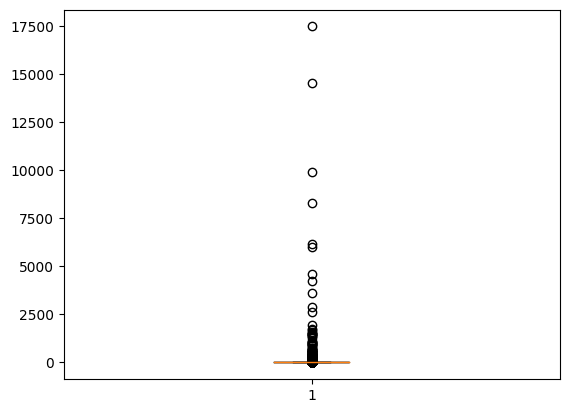

In [ ]:
plt.boxplot(N_word)
plt.show()

In [ ]:
N_word[N_word['N']>5000]

N
to    6028
and   6165
of    8319
.     9905
,    14518
the  17474

In [ ]:
N_word[N_word['N']<2]

N
paralysis       1
vomitings       1
retchings       1
fellow-workman  1
affirmative     1
...            ..
car-to-car      1
selvages        1
contractility   1
conceded        1
transpire       1

[5921 rows x 1 columns]

In [ ]:
waveform, sample_rate, text, _  = train_set(0)

Sample Rate:  22050
Shape:  (1, 217501)
DType:  torch.float32
 - Max:    0.474
 - Min:   -0.413
 - Mean:   -0.000
 - Std Dev:    0.061

tensor([[0.0003, 0.0004, 0.0003,  ..., 0.0013, 0.0012, 0.0002]])



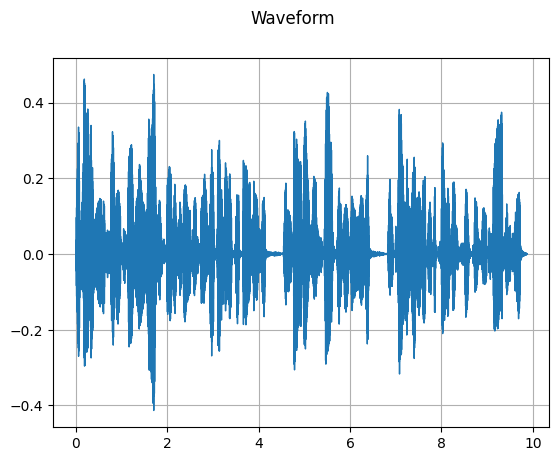

In [ ]:
print_stats(waveform, sample_rate)
plot_waveform(waveform, sample_rate)
mel_spectro = T.MelSpectrogram(sample_rate, n_fft = 1024, hop_length = 128, n_mels = 150)
spec = mel_spectro(waveform)

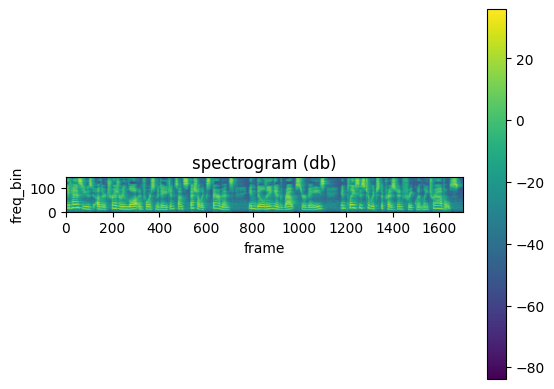

In [ ]:
plot_spectrogram(spec[0])

In [ ]:
text

'It has used other Treasury law enforcement agents on special experiments in building and route surveys in places to which the President frequently travels.'

In [ ]:
Audio(waveform.numpy(), rate = sample_rate)

In [ ]:
wav_info = []
for i in range(len(train_set)):
  sample, sample_rate, _, _  = train_set(i)
  wav_info.append([sample.shape[1]/sample_rate, sample.mean().item(), sample.std().item()])

In [ ]:
wav_df = pd.DataFrame(wav_info, columns = ['time', 'mean', 'std'])
wav_df.describe()

time          mean           std
count  12500.000000  12500.000000  12500.000000
mean       6.576561      0.000009      0.066083
std        2.182036      0.000008      0.009615
min        1.110068     -0.000074      0.032051
25%        4.987800      0.000004      0.059395
50%        6.764127      0.000008      0.065272
75%        8.389524      0.000013      0.071681
max       10.096190      0.000068      0.130990

### average mean = 0.000009 ||| average std = 0.066083

## 🟢 **CustomDataset**




In [ ]:
class LJSpeechDataset(Dataset):
  def __init__(self, dataset, tokenizer, vocab, transform = None):
    super(LJSpeechDataset, self).__init__()
    self.dataset    = dataset
    self.tokenizer  = tokenizer
    self.vocab      = vocab
    self.transform  = transform

  def __getitem__(self, idx):
    waveform, sample_rate, _, text= self.dataset(idx)

    if self.transform:
      waveform = self.transform(waveform)

    characters = list(text)
    characters.append('>')
    characters.insert(0, '<')
    text_idx = [self.vocab[character.lower()] for character in characters]
    target   = torch.LongTensor(text_idx)

    return waveform.squeeze(), target

  def __len__(self):
    return len(self.dataset)

In [ ]:
gc.collect()
train_dataset = LJSpeechDataset(train_set, tokenizer, ch_vocab, None)
valid_dataset = LJSpeechDataset(valid_set, tokenizer, ch_vocab, None)
test_dataset  = LJSpeechDataset(test_set, tokenizer , ch_vocab, None)

In [ ]:
len(train_dataset), len(valid_dataset), len(test_dataset)

(12500, 100, 500)

In [ ]:
waveform, taregt = train_dataset[1]
waveform.shape, taregt

(torch.Size([220573]),
 tensor([ 2,  6,  8,  4,  7, 26,  7, 10, 15,  4, 13, 10, 19, 11,  5, 15, 17,  4,
          8, 17,  4, 13, 10, 11,  4, 21,  8, 20,  5, 12, 11, 25,  4,  7, 11,  4,
         10,  6,  4, 20,  7, 11,  4, 14, 10, 17, 17, 10, 16, 18, 15,  6,  4,  6,
          8,  4, 24, 12, 10,  9, 22,  4, 13,  8, 19,  5,  4,  6, 13,  5,  4, 14,
          5, 12,  5, 15, 10, 16,  6, 10,  8,  9, 11,  4,  8, 17,  4, 14, 18,  6,
         10,  5, 11,  4,  7,  9, 14,  4,  5, 26,  7, 11, 10,  8,  9,  4,  8, 17,
          4,  6, 13,  5,  4,  7, 16,  6, 11, 27,  4,  6,  8,  8,  4, 19, 18, 16,
         13,  4, 20,  7, 11,  4, 15,  5, 17,  6,  4,  6,  8,  4,  6, 13,  5,  4,
         10,  9, 11, 21,  5, 16,  6,  8, 12, 11, 27,  3]))

## 🟢 **Visualize**

In [ ]:
import random
def visualize_random_sample(n, dataset, vocab):

  n_random_idx = random.sample(range(0, len(dataset) - 1), n)

  audios = []
  texts  = []
  for idx in n_random_idx:

      wavform, text_idx = dataset[idx]
      audios.append(Audio(wavform, rate = 22050))
      display(plot_waveform(wavform.unsqueeze(0), 22050))
      display(Audio(wavform, rate = 22050))


      text = [vocab.get_itos()[index] for index in text_idx.tolist()]
      texts.append(text)
      print(''.join(text))

  return audios, texts

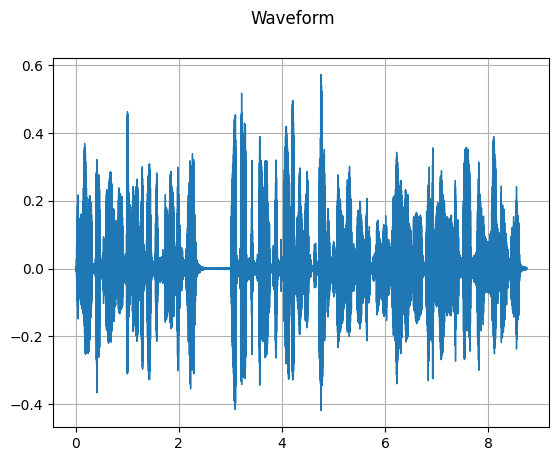

None

<and was extremely believable before this. we thought the fellow could probably get quite a few members if he was really indeed serious about getting members.>


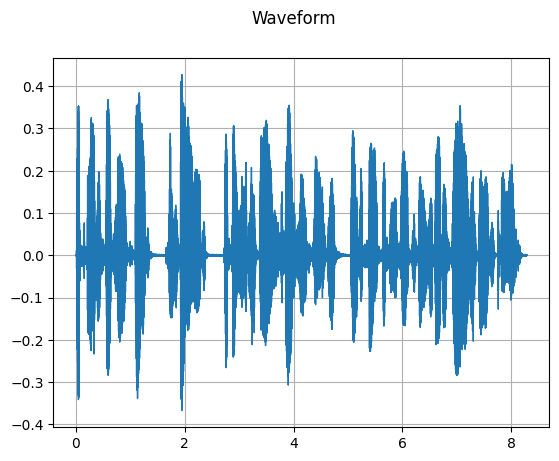

None

<reported that lee, quote, confided that the worse thing about youth house was the fact that he had to be with other boys all the time,>


In [ ]:
audios, texts = visualize_random_sample(2, train_dataset, ch_vocab)

## 🟢 **DataLoader**

In [ ]:
def collate_fn(batch):
  samples = [b[0] for b in batch]
  samples = pad_sequence(samples, batch_first = True, padding_value = ch_vocab['=']).unsqueeze(1)
  targets  = [b[1] for b in batch]
  targets  = pad_sequence(targets, batch_first = True, padding_value = ch_vocab['='])

  return samples, targets

In [ ]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, collate_fn = collate_fn)
valid_loader = DataLoader(valid_dataset, batch_size = 32, shuffle = False, collate_fn = collate_fn)
test_loader  = DataLoader(test_dataset , batch_size = 32, shuffle = False, collate_fn = collate_fn)

In [ ]:
input, target = next(iter(train_loader))

In [ ]:
input.shape, target.shape

# 🔵 **Model**

## 🔵 **Feature Extractor**

In [ ]:
class CNN2DFeatureExtractor(nn.Module):

  def __init__(self, inplanes, planes):
    super().__init__()

    self.conv1 = nn.Conv2d(1, inplanes, kernel_size=11, stride=1, padding=5, bias=False)
    self.bn1 = nn.BatchNorm2d(inplanes)
    self.relu = nn.ReLU(inplace=True)
    self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

    self.conv2 = nn.Conv2d(inplanes, planes, kernel_size=11, stride=1, padding=5, bias=False)
    self.bn2 = nn.BatchNorm2d(planes)

    self.conv3 = nn.Conv2d(planes, planes, kernel_size=11, stride=1, padding=5, bias=False)
    self.bn3 = nn.BatchNorm2d(planes)
    self.maxpool2 = nn.MaxPool2d(kernel_size=3, stride=(2, 1), padding=1)

  def forward(self, x):
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)
    x = self.maxpool(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)

    x = self.conv3(x)
    x = self.bn3(x)
    x = self.relu(x)

    x = self.maxpool2(x)

    return x

## 🔵 **Positional Encoding**

In [ ]:
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, embedding_dim]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

## 🔵 **Full Model**

In [ ]:
class Speech2Text(nn.Module):
  def __init__(self, d_model, num_encoder_layer, num_decoder_layer, nhead, dim_forward, dropout,
               vocab_size, sample_rate = 22050, n_mels = 80, n_fft = 400, inplanes = 32, planes = 32, augment = False):
    super(Speech2Text, self).__init__()
    self.d_model = d_model
    #transforms
    self.trnasform = nn.Sequential(T.Resample(orig_freq = sample_rate, new_freq = 16000),
                                   T.MelSpectrogram(n_mels = n_mels, n_fft = n_fft)).requires_grad_(False)
    self.augment = augment
    if augment:
      self.augmentation = nn.Sequential(T.TimeMasking(30, p = 0.5))

    #CNN feature extractor
    self.feature_extractor = CNN2DFeatureExtractor(inplanes=inplanes, planes=planes)
    #Positional Encoding
    self.pos_encoder = PositionalEncoding(d_model, dropout)
    #Embedding
    self.embedding  = nn.Embedding(vocab_size, d_model, ch_vocab['='])
    #Transformer
    self.transformer = nn.Transformer(
        d_model=d_model, nhead=nhead,
        num_encoder_layers=num_encoder_layer, num_decoder_layers=num_decoder_layer,
        dim_feedforward=dim_forward,
        dropout=dropout, activation=nn.functional.relu
        )
    #Classification Head
    self.cls_head = nn.Linear(self.d_model, vocab_size)
    self.init_weights()
    self.init_weights_e()

  def init_weights(self) -> None:
    initrange = 0.1
    self.cls_head.bias.data.zero_()
    self.cls_head.weight.data.uniform_(-initrange, initrange)

  def init_weights_e(self) -> None:
      initrange = 0.1
      self.embedding.weight.data.uniform_(-initrange, initrange)

  def forward(self, audio, tokens):
    with torch.no_grad():
      y = self.trnasform(audio)
      if self.augment:
        y = self.augmentation(y)
    y = self.feature_extractor(y)
    batch_size, num_channels, freq_bins, seq_len = y.shape
    y = y.reshape(batch_size, -1, seq_len)
    y = y.permute(2, 0, 1)
    tokens = self.embedding(tokens) * math.sqrt(self.d_model)

    tokens = tokens.permute(1, 0, 2)
    tokens = self.pos_encoder(tokens)
    tokens_mask = nn.Transformer.generate_square_subsequent_mask(len(tokens)).to(device)

    out = self.transformer(y, tokens, tgt_mask=tokens_mask)
    out = out.permute(1, 0, 2)
    out = self.cls_head(out)

    return out

In [ ]:
model = Speech2Text(640, 4, 1, 2, 640, 0.1, ch_vocab_size, 22050).to(device)

In [ ]:
num_trainable_params(model)

In [ ]:
audio, tokens = next(iter(train_loader))

In [ ]:
audio.shape, tokens.shape

In [ ]:
model(audio.to(device), tokens[:, 0:-1].to(device)).shape

# 🔵 **Config**


In [ ]:
loss_func = nn.CrossEntropyLoss()
metric = tm.text.WordErrorRate().to(device)

# 🔵 **Train**

In [ ]:
def train_one_epoch(model, train_loader, loss_fn, optimizer, shedular, metric, epoch=None):
  model.train()
  loss_train = AverageMeter()
  metric.reset()

  with tqdm.tqdm(train_loader, unit='batch') as tepoch:
    for audios, tokens in tepoch:
      if epoch or epoch == 0:
        tepoch.set_description(f'Epoch {epoch}')


      audios  = audios.to(device)
      tokens   = tokens.to(device)

      outputs = model(audios, tokens[:, 0:-1])

      loss = loss_fn(outputs.permute(0, 2, 1), tokens[:, 1:])

      loss.backward()

      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()
      if shedular:
        shedular.step()
      optimizer.zero_grad()

      loss_train.update(loss.item())
      pred_sentences, input_sentences = to_sentence(outputs, tokens)
      metric.update(pred_sentences, input_sentences)


      tepoch.set_postfix(loss=loss_train.avg, WER=metric.compute().item())

  return model, loss_train.avg, metric.compute().item()

# 🔵 **Evaluate**

In [ ]:
def evaluate(model, data_loader, loss_fn, metric):
  model.eval()
  metric.reset()

  loss_valid = AverageMeter()

  for audios, tokens in data_loader:

    audios = audios.to(device)
    tokens = tokens.to(device)
    with torch.no_grad():
      outputs = model(audios, tokens[:, 0:-1])

    loss = loss_fn(outputs.permute(0, 2, 1), tokens[:, 1:])
    loss_valid.update(loss)
    pred_sentences, input_sentences = to_sentence(outputs, tokens)

    metric.update(pred_sentences, input_sentences)

  print(f'Loss : {loss_valid.avg.item()}, WER : {metric.compute().item()}')

  return loss_valid.avg.item(), metric.compute().item()

# 🔵 **Transcript**

In [70]:
def speech2text(model, wavform, sample_rate, vocab, real_text, metric, show = False):
  model.eval()

  input = wavform.unsqueeze(0)

  tokens = torch.LongTensor([vocab['<']]).unsqueeze(0)
  end = False
  counter = 0
  while(end == False):

    with torch.no_grad():
      new_token = model(input.to(device), tokens.to(device))[:, -1, :]

    index = new_token.argmax(dim = -1)

    if index.item() == vocab['>']:
      tokens = torch.cat([tokens, torch.LongTensor([index.item()]).unsqueeze(0)], dim = -1)
      end = True

    elif counter == 1000:
      end = True

    else:
      tokens = torch.cat([tokens, torch.LongTensor([index.item()]).unsqueeze(0)], dim = -1)
      counter += 1

  text = ''.join([vocab.get_itos()[idx] for idx in tokens.squeeze().tolist()])
  text = text.replace('<', '')
  text = text.replace('>', '')
  real_text = ''.join([vocab.get_itos()[idx] for idx in real_text.squeeze().tolist()])
  real_text = real_text.replace('<', '')
  real_text = real_text.replace('>', '')

  if show:
    display(Audio(wavform, rate = sample_rate))
    display(f'predict = {text}')
    print()
    display(f'real = {real_text}')
    print()
    display(metric([text], [real_text]))
  return [text], [real_text]

# 🔵 **Training Peocess**

## 🔵 **Main Loop**

In [ ]:
torch.cuda.empty_cache()

In [ ]:
set_seed(8)
model = Speech2Text(640, 2, 3, 16, 640, 0.1, ch_vocab_size, 22050, augment = True).to(device)
num_trainable_params(model)

In [ ]:
set_seed(8)
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = True, collate_fn = collate_fn, num_workers = 2)

In [ ]:
train_loss_hist, valid_loss_hist = [], []
train_metric_hist, valid_metric_hist  =[], []
best_metric = torch.inf
best_loss   = torch.inf

In [ ]:
lr = 0.15
wd = 1e-4
optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = wd, momentum = 0.9, nesterov = True)
shedular  = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max = 20000, eta_min = 1e-7)
loss_func = nn.CrossEntropyLoss(ignore_index = ch_vocab['='])
metric    = tm.text.WordErrorRate().to(device)

In [57]:
set_seed(8)

start, stop = 0, 30
wait = 0

for i in range(start, stop):

  model, train_loss, train_metric = train_one_epoch(model, train_loader, loss_func, optimizer, None, metric, i)
  valid_loss, valid_metric        = evaluate(model, valid_loader, loss_func, metric)

  train_loss_hist.append(train_loss)
  valid_loss_hist.append(valid_loss)
  train_metric_hist.append(train_metric)
  valid_metric_hist.append(valid_metric)

  if valid_loss<best_loss:
    best_loss = valid_loss

  if valid_metric<best_metric:
    torch.save(model, 'best_model.pt')
    print('model saved!')
    wait = 0
    best_metric = valid_metric

  if valid_loss>best_loss and valid_metric>best_metric:
    wait += 1
    if wait >= 3 and i >= 25:
      lr = 0.5 * lr
      print(f'change LR!>>>>new LR = {lr}')
      wd = 1/0.7 *  wd
      optimizer = optim.SGD(model.parameters(), lr = lr, weight_decay = wd, momentum = 0.9)
      wait = 0

Epoch 0: 100%|██████████| 391/391 [04:38<00:00,  1.40batch/s, WER=1.34, loss=2.76]


Loss : 2.241962432861328, WER : 1.0762250423431396
model saved!


Epoch 1: 100%|██████████| 391/391 [04:43<00:00,  1.38batch/s, WER=1.15, loss=2.02]


Loss : 1.771547794342041, WER : 1.0568662881851196
model saved!


Epoch 2: 100%|██████████| 391/391 [04:43<00:00,  1.38batch/s, WER=1.06, loss=1.74]


Loss : 1.591955542564392, WER : 0.9915305376052856
model saved!


Epoch 3: 100%|██████████| 391/391 [04:43<00:00,  1.38batch/s, WER=1.03, loss=1.59]


Loss : 1.5002139806747437, WER : 1.0024198293685913


Epoch 4: 100%|██████████| 391/391 [04:43<00:00,  1.38batch/s, WER=1.02, loss=1.5]


Loss : 1.4040217399597168, WER : 0.9697519540786743
model saved!


Epoch 5: 100%|██████████| 391/391 [04:44<00:00,  1.37batch/s, WER=1, loss=1.42]


Loss : 1.3430352210998535, WER : 0.9618874788284302
model saved!


Epoch 6: 100%|██████████| 391/391 [04:43<00:00,  1.38batch/s, WER=0.988, loss=1.33]


Loss : 1.2157491445541382, WER : 0.9485783576965332
model saved!


Epoch 7: 100%|██████████| 391/391 [04:44<00:00,  1.38batch/s, WER=0.947, loss=1.16]


Loss : 1.1076810359954834, WER : 0.9449485540390015
model saved!


Epoch 8: 100%|██████████| 391/391 [04:43<00:00,  1.38batch/s, WER=0.872, loss=0.951]


Loss : 1.2395851612091064, WER : 0.8977616429328918
model saved!


Epoch 9: 100%|██████████| 391/391 [04:44<00:00,  1.37batch/s, WER=0.807, loss=0.805]


Loss : 1.0462641716003418, WER : 0.8880822658538818
model saved!


Epoch 10: 100%|██████████| 391/391 [04:43<00:00,  1.38batch/s, WER=0.762, loss=0.714]


Loss : 1.2776634693145752, WER : 0.9413188099861145


Epoch 11: 100%|██████████| 391/391 [04:43<00:00,  1.38batch/s, WER=0.727, loss=0.647]


Loss : 0.6752906441688538, WER : 0.7283726334571838
model saved!


Epoch 12: 100%|██████████| 391/391 [04:43<00:00,  1.38batch/s, WER=0.698, loss=0.598]


Loss : 1.0919969081878662, WER : 0.901996374130249


Epoch 13: 100%|██████████| 391/391 [04:43<00:00,  1.38batch/s, WER=0.674, loss=0.555]


Loss : 1.4748871326446533, WER : 0.895946741104126


Epoch 14: 100%|██████████| 391/391 [04:43<00:00,  1.38batch/s, WER=0.652, loss=0.521]


Loss : 1.1669023036956787, WER : 0.9147005677223206


Epoch 15: 100%|██████████| 391/391 [04:44<00:00,  1.37batch/s, WER=0.636, loss=0.494]


Loss : 1.4579784870147705, WER : 0.9328493475914001


Epoch 16: 100%|██████████| 391/391 [04:43<00:00,  1.38batch/s, WER=0.62, loss=0.471]


Loss : 0.8736328482627869, WER : 0.8009679317474365


Epoch 17: 100%|██████████| 391/391 [04:42<00:00,  1.38batch/s, WER=0.61, loss=0.453]


Loss : 0.5701642036437988, WER : 0.6878402829170227
model saved!


Epoch 18: 100%|██████████| 391/391 [04:43<00:00,  1.38batch/s, WER=0.604, loss=0.437]


Loss : 0.5035163760185242, WER : 0.6418632864952087
model saved!


Epoch 19: 100%|██████████| 391/391 [04:43<00:00,  1.38batch/s, WER=0.594, loss=0.422]


Loss : 2.4379539489746094, WER : 0.9945553541183472


Epoch 20: 100%|██████████| 391/391 [04:42<00:00,  1.38batch/s, WER=0.584, loss=0.412]


Loss : 0.8279711008071899, WER : 0.794313371181488


Epoch 21: 100%|██████████| 391/391 [04:43<00:00,  1.38batch/s, WER=0.575, loss=0.4]


Loss : 0.5083792805671692, WER : 0.6043556928634644
model saved!


Epoch 22: 100%|██████████| 391/391 [04:42<00:00,  1.38batch/s, WER=0.565, loss=0.389]


Loss : 1.028133749961853, WER : 0.8439201712608337


Epoch 23: 100%|██████████| 391/391 [04:43<00:00,  1.38batch/s, WER=0.56, loss=0.38]


Loss : 0.769752025604248, WER : 0.7797943353652954


Epoch 24: 100%|██████████| 391/391 [04:43<00:00,  1.38batch/s, WER=0.553, loss=0.372]


Loss : 1.4240058660507202, WER : 1.0284332036972046


Epoch 25: 100%|██████████| 391/391 [04:42<00:00,  1.38batch/s, WER=0.547, loss=0.369]


Loss : 0.8821988701820374, WER : 0.8215366005897522
change LR!>>>>new LR = 0.075


Epoch 26: 100%|██████████| 391/391 [04:42<00:00,  1.38batch/s, WER=0.489, loss=0.299]


Loss : 1.6786655187606812, WER : 1.0314579010009766


Epoch 27: 100%|██████████| 391/391 [04:42<00:00,  1.38batch/s, WER=0.483, loss=0.287]


Loss : 0.48283106088638306, WER : 0.61524498462677


Epoch 28: 100%|██████████| 391/391 [04:42<00:00,  1.38batch/s, WER=0.483, loss=0.289]


Loss : 0.36178070306777954, WER : 0.5021173357963562
model saved!


Epoch 29: 100%|██████████| 391/391 [04:42<00:00,  1.38batch/s, WER=0.487, loss=0.29]


Loss : 0.39637237787246704, WER : 0.5384150147438049


### 🔵 **Plot**

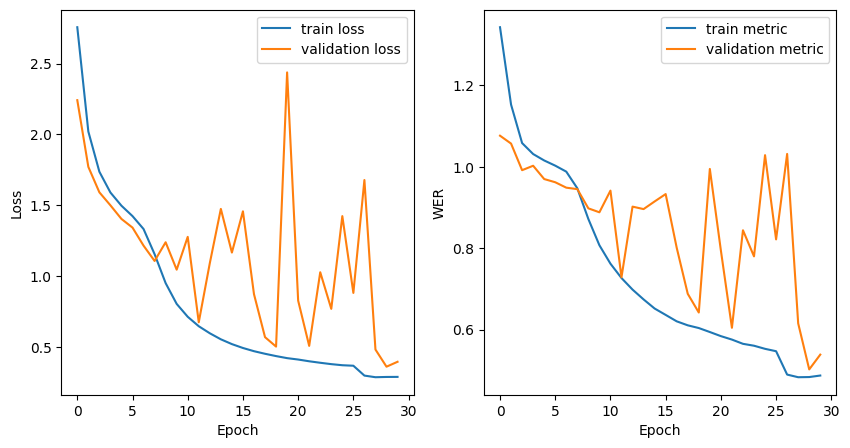

In [58]:
plt.figure(figsize = (10, 5))

plt.subplot(1, 2, 1)
plt.plot(range(stop), train_loss_hist, label = 'train loss')
plt.plot(range(stop), valid_loss_hist, label = 'validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_metric_hist, label = 'train metric')
plt.plot(valid_metric_hist, label = 'validation metric')
plt.xlabel('Epoch')
plt.ylabel('WER')
plt.legend()
plt.show()

# 🔵 **Test**

In [63]:
model = torch.load('best_model.pt').to(device).eval()
model.augment = False

In [64]:
with torch.no_grad():
  _, _ = evaluate(model, test_loader, loss_func, metric)

Loss : 0.3020555377006531, WER : 0.482575923204422


# 🔵 **Speech2Text**

In [65]:
model = torch.load('best_model.pt').to(device).eval()
model.augment = False

In [71]:
idx_list = [0, 3, 6, 9, 36, 39, 63, 69, 93, 96, 129, 132, 123, 111, 196, 369, 255]
for idx in idx_list:
  wavform, real_text= test_dataset[idx]
  speech2text(model, wavform.unsqueeze(0), 22050, ch_vocab, real_text, metric, show = True)

'predict = mrs. demornshildt fall that oswald of that oswald was walled, falk that oswald at oswald, oswald, falk that oswald, at oswald, falk that oswald,'

'real = mrs. de mohrenschildt thought that oswald,'

tensor(3.5000, device='cuda:0')

'predict = the prisoner had nothing toping and chopying and chopying and chopying and chopying and chopying and chopying and choping and chopying and chopy end got would now reve.'

'real = the prisoner had nothing to deal with but wooden panels, and by dint of cutting and chopping he got both the lower panels out.'

tensor(0.9167, device='cuda:0')

'predict = it is not ossible to state with sirtnenty, that of a particular small room of serten peace of certain peace of certainty, that of a fivers comfrom of serten peas of signg.'

'real = it is not possible to state with scientific certainty that a particular small group of fibers come from a certain piece of clothing'

tensor(0.8696, device='cuda:0')

'predict = j., d., d., end marrine shildt, said, quote, said, quote, said, quote, said, quote, said, quote,'

'real = jeanne de mohrenschildt said, quote,'

tensor(2.8000, device='cuda:0')

'predict = door give the met its by which they were purpoterate greatly daried greatly daried greatly daried greatly daried greatly daried greatly daried great leevery.'

'real = nor did the methods by which they were perpetrated greatly vary from those in times past.'

tensor(1.1250, device='cuda:0')

'predict = there month ruins, they still lead in the same condivances, they still lead in the same condivances, they still lead in the same cond a houses,'

'real = there among the ruins they still live in the same kind of houses,'

tensor(1.3846, device='cuda:0')

'predict = the presidential limousine arrived of the emergency entrance of the parkland hospital at about thirty-five p.m., at about thirty-five p.m.'

'real = the presidential limousine arrived at the emergency entrance of the parkland hospital at about twelve:thirty-five p.m.'

tensor(0.3750, device='cuda:0')

'predict = were governmed by were govern by wells had framed, and under which subscrions were levy these and gonder which subscrions were levy dead on the even selves had frame.'

'real = were governed by rules which they themselves had framed, and under which subscriptions were levied'

tensor(1.4000, device='cuda:0')

'predict = to select a sufficient light and arrected prison which the sufficiently spacies should be inconformed one of one of oundations to round form formerity with,'

'real = to select a sufficiently spacious piece of ground, and erect a prison which from foundations to roofs should be in conformity with the newest ideas.'

tensor(0.8800, device='cuda:0')

'predict = the keeper unmunds angestly over the combustible essembly, but his eyes to appear unmul stable esombly. but his eye want angestly over the combust of all esombly.'

'real = the keeper tries to appear unmoved, but his eye wanders anxiously over the combustible assembly.'

tensor(1.2000, device='cuda:0')

'predict = his disclaimer simply for a fec. was intended simply for a fec. was intended simply for a fec. was intended simply for a fec.'

'real = his disclaimer, distinct and detailed on every point, was intended simply for effect.'

tensor(1.4615, device='cuda:0')

'predict = he did not rise of all fine insamination for the rank of private first klass accolve five it first class a qualfiend in though he had passed a qualfirsh class'

'real = he did not rise above the rank of private first class, even though he had passed a qualifying examination for the rank of corporal.'

tensor(0.8333, device='cuda:0')

'predict = they ture on himself to the personal investigation of the prisons of the united states, states, he had devoted himself to the first of first on the prisons of the unitedated s.'

'real = later on he had devoted himself to the personal investigation of the prisons of the united states.'

tensor(1.2353, device='cuda:0')

'predict = within a few weeks of murderer undoubtably was insfired by the facts made public effacts made public effacts made heaves poisoning case,'

"real = within a few weeks occurred the leeds poisoning case, in which the murderer undoubtedly was inspired by the facts made public at palmer's trial."

tensor(0.7500, device='cuda:0')

'predict = i were reform refull more of more of markable murders in the utlegrand cast onto enough of the more of markable murders in the utler branch onway.'

'real = i will briefly describe one or two of the more remarkable murders in the years immediately following, then pass on to another branch of crime.'

tensor(0.9600, device='cuda:0')

'predict = who had boarnett, in the tenth huscers. as corned the cousers, as corned the cousers, as cornet, in the tenth huscers.'

"real = who had borne the queen's commission, first as cornet, and then lieutenant, in the tenth hussars."

tensor(0.8750, device='cuda:0')

'predict = the lax discipline maintained in mates of such jail, who at never to have been in mates of such jail, and ever to have been inmates of such jail,'

'real = the lax discipline maintained in newgate was still further deteriorated by the presence of two other classes of prisoners who ought never to have been inmates of such a jail.'

tensor(0.6000, device='cuda:0')